In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition as dcp

from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [2]:
%matplotlib inline

In [3]:
cd /lustre/scratch109/sanger/pc13/mouse/64somites/

/lustre/scratch109/sanger/pc13/mouse/64somites


In [4]:
ddf = pd.read_table(open('10somites_v_11somites.tsv'))
#ddf2 = pd.read_table(open('/lustre/scratch109/sanger/ip7/Nek9-rnaseq/wt_vs_hom.tsv'))
#ndf = pd.merge(ddf, ddf2, on='Gene ID', how='outer')
ndf=ddf
cols = ndf.keys()[11:75] 
#| ndf.keys()[-30:-15]
counts_df=ndf[cols]
genes = ndf['Gene ID']
counts_df.index=genes
#counts_df = counts_df[counts_df.keys()[1:]]
counts_df
gene_df = counts_df.T
nums = pd.Series([int(tt.split('somites')[0]) for tt in gene_df.index.tolist()])
grouped = counts_df.groupby(nums)

In [5]:
#hacked from normpy normalizers
def _sf_deseq(counts):
    """
    Calculate DESeq scaling factor per sample.
    """
    # masked array to discard inf, -inf, and nan
    ma = np.ma.masked_invalid(counts)
    return np.exp(np.ma.median(ma))

def norm_deseq(pd_expression):
    """
    Normalize by DESeq scaling factor, which is computed as the median of
    the ratio, for each row (gene), of its read count over its geometric
    mean across all samples. Return new counts dataframe.
    Details:
    --------
    http://genomebiology.com/2010/11/10/R106
    Parameters:
    -----------
    - exp_obj: experiment object. Normalized by DESeq scaling factor.
    """
    df = pd_expression.copy()
    # log of counts
    lg = df.apply(np.log)
    # per sample: exponential(median(log(counts) - geometric mean))
    sf = lg.sub(lg.mean(axis=1), axis=0).apply(_sf_deseq, axis=0)
    # apply scaling
    df = df.div(sf, axis=1)
    return df, sf

In [6]:
normed, scaling = norm_deseq(counts_df)
lg_normed = normed.apply(np.log)
lg_nexpr = lg_normed.T
lg_noinf_nexpr = lg_nexpr.replace(-np.inf, 0)

In [7]:
def name_number_map(name):
    if 'somites' in name:
        return int(''.join(name.split()[0].split('somites_')))
    else:
        return 40+int(name.split()[0][-2:])

In [8]:
count_totals = normed.T.sum()
genes_gt_500_counts = count_totals[count_totals>500].index
gt500_df = normed[normed.index.isin(genes_gt_500_counts)]
name_maps = {name_number_map(kk):kk for kk in gt500_df.keys()}
sorted_nums = name_maps.keys()
sorted_nums.sort()
gt500_df = gt500_df[[name_maps[kk] for kk in sorted_nums]]

In [9]:
#staging_genes = [line.strip() for line in open('molecular_staging_working/tight_512_ensgs.txt')]
#sg = pd.Series(staging_genes)
stage_df = gt500_df #.ix[staging_genes]
inds = pd.isnull(stage_df).any(1).nonzero()[0]
sdf = stage_df.drop(stage_df.index[inds])
spca = dcp.PCA(n_components=64, whiten=True).fit(sdf)
rpca = dcp.RandomizedPCA(n_components=64, whiten=True).fit(sdf)
pca = dcp.PCA(n_components=64, whiten=True).fit(sdf)
rpca_not_white = dcp.RandomizedPCA(n_components=64, whiten=False).fit(sdf)
fica = dcp.FastICA(n_components=1, whiten=True).fit(sdf)
eigenexpressions = rpca.components_.reshape((64, 1, 64))

In [10]:
from collections import defaultdict

In [11]:
somite2cols = defaultdict(list)

In [12]:
for kk in counts_df.keys():
    somite2cols[kk.split('somites')[0]].append(kk)

In [13]:
somite2cols

defaultdict(list,
            {'10': ['10somites_1 count',
              '10somites_2 count',
              '10somites_3 count',
              '10somites_4 count'],
             '11': ['11somites_1 count',
              '11somites_2 count',
              '11somites_3 count',
              '11somites_4 count'],
             '13': ['13somites_1 count',
              '13somites_2 count',
              '13somites_3 count',
              '13somites_4 count'],
             '14': ['14somites_1 count',
              '14somites_2 count',
              '14somites_3 count',
              '14somites_4 count'],
             '21': ['21somites_1 count',
              '21somites_2 count',
              '21somites_3 count',
              '21somites_4 count'],
             '22': ['22somites_1 count',
              '22somites_2 count',
              '22somites_3 count',
              '22somites_4 count'],
             '23': ['23somites_1 count',
              '23somites_2 count',
              '23somites

In [15]:
somite_dfs = {kk:sdf[somite2cols[kk]] for kk in somite2cols}

In [16]:
somite_dfs

{'10':                     10somites_1 count  10somites_2 count  10somites_3 count  \
 Gene ID                                                                       
 ENSMUSG00000030905          23.100274          19.476199          19.383754   
 ENSMUSG00000048540           0.888472           2.655845           1.615313   
 ENSMUSG00000019874          11.550137          24.787890          25.845005   
 ENSMUSG00000013698         944.445802         972.924669         943.342683   
 ENSMUSG00000027805         520.644628         568.350899         568.590110   
 ENSMUSG00000060424           6.219304           7.967536           8.884220   
 ENSMUSG00000062380         231.891208         208.041217         210.798322   
 ENSMUSG00000026452           3.553888           2.655845           5.653595   
 ENSMUSG00000022044           2.665416           0.885282           1.615313   
 ENSMUSG00000020810           8.884721           8.852818           8.884220   
 ENSMUSG00000019230           5.33

In [17]:
from scipy import stats

In [46]:
anova_dict = {}

for gene in sdf.index:
    f_val, p_val = stats.f_oneway(somite_dfs['6'].ix[gene],somite_dfs['7'].ix[gene], somite_dfs['8'].ix[gene],somite_dfs['9'].ix[gene],somite_dfs['10'].ix[gene],somite_dfs['11'].ix[gene],somite_dfs['13'].ix[gene],somite_dfs['14'].ix[gene],somite_dfs['21'].ix[gene],somite_dfs['22'].ix[gene],somite_dfs['23'].ix[gene],somite_dfs['24'].ix[gene],somite_dfs['25'].ix[gene],somite_dfs['26'].ix[gene],somite_dfs['35'].ix[gene],somite_dfs['36'].ix[gene])
    anova_dict[gene] = (f_val, p_val)

In [20]:
import cPickle as pkl

In [21]:
pkl.dump(anova_dict, open('anova_de_normed.pkl','w'))

seaborn.violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100, width=0.8, inner='box', split=False, orient=None, linewidth=None, color=None, palette=None, saturation=0.75, ax=None, **kwargs)

best n_components by PCA CV = 45
best n_components by FactorAnalysis CV = 15
best n_components by PCA MLE = 62


NameError: name 'title' is not defined

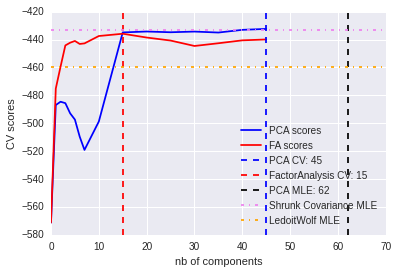

In [28]:
n_components = np.array([ 0,  1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30, 35, 40, 45])

def compute_scores(X):
    pca = PCA()
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


X = sdf 

pca_scores, fa_scores = compute_scores(X)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

pca = PCA(n_components='mle')
pca.fit(X)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(n_components_pca, color='b',
            label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
            label='FactorAnalysis CV: %d' % n_components_fa, linestyle='--')
plt.axvline(n_components_pca_mle, color='k',
            label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
plt.axhline(shrunk_cov_score(X), color='violet',
            label='Shrunk Covariance MLE', linestyle='-.')
plt.axhline(lw_score(X), color='orange',
            label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
#plt.title(title)

plt.show()

best n_components by PCA CV = 45
best n_components by FactorAnalysis CV = 15
best n_components by PCA MLE = 62


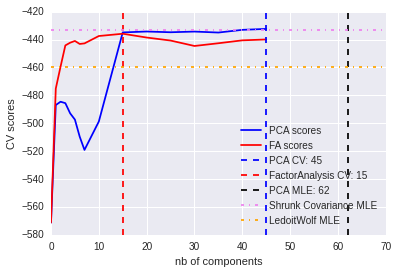

In [29]:
print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(n_components_pca, color='b',
            label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
            label='FactorAnalysis CV: %d' % n_components_fa, linestyle='--')
plt.axvline(n_components_pca_mle, color='k',
            label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
plt.axhline(shrunk_cov_score(X), color='violet',
            label='Shrunk Covariance MLE', linestyle='-.')
plt.axhline(lw_score(X), color='orange',
            label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
#plt.title(title)

plt.show()

In [30]:
fa_scores

[-571.18819670747348,
 -475.18823814333899,
 -459.43010091161381,
 -444.24087007206231,
 -442.30644961692059,
 -441.03228856029727,
 -443.20321192813191,
 -442.79471603452339,
 -437.50529312127651,
 -435.86805241865568,
 -438.59127290112218,
 -440.75468397002459,
 -444.64008030040009,
 -442.68692642323236,
 -440.60743567764024,
 -439.96745678880137]

In [33]:
fa = FactorAnalysis(n_components=3, max_iter=20)

In [34]:
fan = fa.fit(sdf)

In [ ]:
fan.

In [35]:
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
tls.set_credentials_file(username='fourpartswater', api_key='39x1bt1vpw')

In [36]:
oname_maps = {name_number_map(kk):kk for kk in gt500_df.keys()}
osorted_nums = oname_maps.keys()
osorted_nums.sort()

In [37]:
trace1 = Scatter3d(x=pca.components_[0], y=pca.components_[1], z=pca.components_[2], mode='markers', text=osorted_nums, marker=Marker(size=2, color=osorted_nums, colorscale='Jet'))
data = Data([trace1])
layout = Layout(title='normed_PCA_all_embryos_all_genes')
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='normed_PCA_all_embryos_all_genes')

In [38]:
trace1 = Scatter3d(x=fan.components_[0], y=fan.components_[1], z=fan.components_[2], mode='markers', text=osorted_nums, marker=Marker(size=2, color=osorted_nums, colorscale='Jet'))
data = Data([trace1])
layout = Layout(title='normed_FA_all_embryos_all_genes')
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='normed_FA_all_embryos_all_genes')

In [39]:
staging_genes = [line.strip() for line in open('molecular_staging_working/tight_512_ensgs.txt')]
sg = pd.Series(staging_genes)
stage_df = gt500_df.ix[staging_genes]
inds = pd.isnull(stage_df).any(1).nonzero()[0]
sdf = stage_df.drop(stage_df.index[inds])
spca = dcp.PCA(n_components=64, whiten=True).fit(sdf)
rpca = dcp.RandomizedPCA(n_components=64, whiten=True).fit(sdf)
pca = dcp.PCA(n_components=64, whiten=True).fit(sdf)
rpca_not_white = dcp.RandomizedPCA(n_components=64, whiten=False).fit(sdf)
fica = dcp.FastICA(n_components=1, whiten=True).fit(sdf)
eigenexpressions = rpca.components_.reshape((64, 1, 64))

In [40]:
fa = FactorAnalysis(n_components=15, max_iter=10)
fan = fa.fit(sdf)

In [41]:
trace1 = Scatter3d(x=pca.components_[0], y=pca.components_[1], z=pca.components_[2], mode='markers', text=osorted_nums, marker=Marker(size=2, color=osorted_nums, colorscale='Jet'))
data = Data([trace1])
layout = Layout(title='normed_PCA_all_embryos_tight_mfuzz_genes')
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='normed_PCA_all_embryos_tight_mfuzz_genes')

In [42]:
trace1 = Scatter3d(x=fan.components_[0], y=fan.components_[1], z=fan.components_[2], mode='markers', text=osorted_nums, marker=Marker(size=2, color=osorted_nums, colorscale='Jet'))
data = Data([trace1])
layout = Layout(title='normed_FA_all_embryos_tight_mfuzz_genes')
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='normed_FA_all_embryos__genes')

In [53]:
pvals = [(anova_dict[vv][1],vv) for vv in anova_dict]

In [54]:
pvals.sort()

In [62]:
staging_genes = [kk[1] for kk in pvals[:3000]]

In [63]:
sg = pd.Series(staging_genes)
stage_df = gt500_df.ix[staging_genes]
inds = pd.isnull(stage_df).any(1).nonzero()[0]
sdf = stage_df.drop(stage_df.index[inds])
spca = dcp.PCA(n_components=64, whiten=True).fit(sdf)
rpca = dcp.RandomizedPCA(n_components=64, whiten=True).fit(sdf)
pca = dcp.PCA(n_components=64, whiten=True).fit(sdf)
rpca_not_white = dcp.RandomizedPCA(n_components=64, whiten=False).fit(sdf)
fica = dcp.FastICA(n_components=1, whiten=True).fit(sdf)
eigenexpressions = rpca.components_.reshape((64, 1, 64))

In [64]:
trace1 = Scatter3d(x=pca.components_[0], y=pca.components_[1], z=pca.components_[2], mode='markers', text=osorted_nums, marker=Marker(size=2, color=osorted_nums, colorscale='Jet'))
data = Data([trace1])
layout = Layout(title='normed_PCA_all_embryos_3k_anova_genes')
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='normed_PCA_all_embryos_3k_anova_genes')

In [66]:
fa = FactorAnalysis(n_components=3, max_iter=30)
fan = fa.fit(sdf)

In [67]:
trace1 = Scatter3d(x=fan.components_[0], y=fan.components_[1], z=fan.components_[2], mode='markers', text=osorted_nums, marker=Marker(size=2, color=osorted_nums, colorscale='Jet'))
data = Data([trace1])
layout = Layout(title='normed_FA_all_embryo_3kanova_genes')
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='normed_FA_all_embryo_3kanova__genes')

In [68]:
fan.components_[0]

array([ 1824.70868781,  1985.26432427,  1937.40913647,  1959.91791175,
        1847.13180575,  1862.03762432,  1957.32205325,  1941.6715151 ,
        1793.76234631,  1824.99895382,  1829.39786732,  1899.37669918,
        1921.83763319,  1885.20682918,  1899.7434972 ,  1894.2183893 ,
        1762.3703453 ,  1828.27139695,  1816.53089311,  1849.91348244,
        1802.61458049,  1722.72142137,  1710.29130443,  1705.15264634,
        1841.5448285 ,  1876.67155583,  1898.71798282,  1867.93395111,
        1755.26791517,  1738.27327747,  1753.2169505 ,  1757.82194421,
        1784.19285529,  1666.72636225,  1787.40372824,  1652.42963792,
        1623.48753462,  1698.59878932,  1678.98436048,  1639.07348312,
        1666.31168234,  1569.16804727,  1623.00127714,  1610.93077676,
        1573.59431038,  1587.98914515,  1627.21632046,  1595.72459392,
        1590.19001296,  1375.14118168,  1384.09916296,  1349.90417941,
        1394.8166936 ,  1661.32410533,  1397.51979887,  1413.78091061,
      

In [71]:
from mvpa2.suite import SimpleSOMMapper

/nfs/users/nfs_p/pc13/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning:

`scipy.weave` is deprecated, use `weave` instead!

/nfs/users/nfs_p/pc13/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning:

`scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.





In [154]:
afembryos4som = np.array(zip(fan.components_[0], fan.components_[1]))
afsom = SimpleSOMMapper((1, 200), 400, learning_rate=0.05)
afsom.train(aembryos4som)

In [156]:
afembryo_names = list(sdf.keys())
afmapped = afsom(afembryos4som)
aforder = zip(afmapped[:,1], afembryo_names)
aforder.sort()
afsomline = [o[1] for o in aforder]

In [157]:
asomline # 6_3 6_1 10_4 10_3 11_3 7_2 10_2 11_1 10_1

['6somites_2 count',
 '6somites_4 count',
 '7somites_3 count',
 '7somites_4 count',
 '7somites_1 count',
 '6somites_3 count',
 '10somites_4 count',
 '8somites_2 count',
 '10somites_3 count',
 '8somites_1 count',
 '8somites_3 count',
 '11somites_3 count',
 '6somites_1 count',
 '9somites_4 count',
 '8somites_4 count',
 '9somites_1 count',
 '9somites_2 count',
 '7somites_2 count',
 '10somites_2 count',
 '11somites_1 count',
 '9somites_3 count',
 '13somites_4 count',
 '11somites_4 count',
 '13somites_2 count',
 '13somites_3 count',
 '13somites_1 count',
 '11somites_2 count',
 '14somites_3 count',
 '14somites_4 count',
 '10somites_1 count',
 '14somites_2 count',
 '14somites_1 count',
 '21somites_3 count',
 '21somites_1 count',
 '22somites_3 count',
 '21somites_2 count',
 '24somites_3 count',
 '23somites_1 count',
 '21somites_4 count',
 '22somites_2 count',
 '23somites_3 count',
 '22somites_1 count',
 '22somites_4 count',
 '23somites_4 count',
 '25somites_1 count',
 '24somites_4 count',
 '24

In [76]:
# embryos_2_remove 6_3 6_1 10_4 10_3 11_3 7_2 10_2 11_1 10_1

In [87]:
embryo_names = list(sdf.keys())
mapped = fan.components_[0]
order = zip(mapped, embryo_names)
order.sort()
all_e_3kanv_fa1_order = [o[1] for o in order]

In [84]:
mapped = fan.components_[1]
order = zip(mapped, embryo_names)
order.sort()
all_e_3kanv_fa2_order = [o[1] for o in order]

In [89]:
all_e_3kanv_fa1_order.reverse()

In [93]:
cd molecular_staging_working/

[Errno 2] No such file or directory: 'molecular_staging_working/'
/lustre/scratch109/sanger/pc13/mouse/64somites/molecular_staging_working


In [96]:
cd ..

/lustre/scratch109/sanger/pc13/mouse/64somites


In [99]:
cd molecular_staging_results/

[Errno 2] No such file or directory: 'molecular_staging_results/'
/lustre/scratch109/sanger/pc13/mouse/64somites/molecular_staging_results


In [102]:
cd genes_from_mfuzz/

[Errno 2] No such file or directory: 'genes_from_mfuzz/'
/lustre/scratch109/sanger/pc13/mouse/64somites/molecular_staging_results/genes_from_mfuzz


In [103]:
ls

2D SOM_2 _files/              all_embryos_1dsom_order2.txt
2D SOM_2 .html                all_embryos_1dsom_order.txt
2d_som_2_positions.tsv        all_embryos_pc1_order.txt
2d_som3.csv                   all_embryos_pc2_order.txt
2D SOM_3.png                  ensembl_genes_for_stage_line.txt
2D SOM.png                    first_two_pcas_stage_64_somites_mouse.tsv
2D_som_positions.tsv          mfuzz128_clusters_for_staging.txt
3dpca.csv                     no_outliers_1dsom_order.txt
3D_pca.tsv                    no_outliers_pc1_order.txt
512_tight_front_extra/        no_outliers_pc2_order.txt
all_512_tight_front_ensg.txt  percentage_explained_variance_by_pc.txt
all_512_tight_front.tsv       unknown_stage_line.pdf


In [108]:
all_1dsom_PCA = [line.strip() for line in open('all_embryos_1dsom_order.txt')]

In [110]:
all_1dsom_PCA.reverse()

In [115]:
from scipy.stats import kendalltau

In [121]:
order = counts_df.keys()

In [124]:
from collections import defaultdict

In [144]:
true_order = []

In [125]:
order_dict = defaultdict(list)
for name in order:
    order_dict[int(name.split('somites')[0])].append(name)  

In [131]:
intorder = order_dict.keys()

In [133]:
intorder.sort()

In [145]:
for x in intorder:
    [true_order.append(kk) for kk in order_dict[x]]

In [147]:
kendalltau(true_order, all_e_3kanv_fa1_order)

KendalltauResult(correlation=0.47222222222222204, pvalue=3.4773403363074508e-08)

In [151]:
kendalltau(true_order, all_e_3kanv_fa2_order)# , all_1dsom_PCA

KendalltauResult(correlation=0.66964285714285687, pvalue=5.2243320177607787e-15)

In [152]:
kendalltau(true_order, all_1dsom_PCA)

KendalltauResult(correlation=0.57142857142857129, pvalue=2.4849532694526076e-11)

In [158]:
kendalltau(true_order, asomline)

KendalltauResult(correlation=0.58630952380952361, pvalue=7.4857522765004372e-12)

In [160]:
len(all_1dsom_PCA)

64